In [53]:
from utility import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Model training

In [2]:
df = pd.read_csv('data/processed/BankChurners_after_preprocessing.csv')

In [3]:
RANDOM_STATE = 5
TARGET_COL_NAME = 'Attrition_Flag'

Main metric will be F1 macro since the dataset is imbalanced

In [4]:
def evaluate(truth, prediction, index):
    acc = metrics.accuracy_score(truth, prediction)
    f1 = metrics.f1_score(truth, prediction, average='macro')
    prec = metrics.precision_score(truth, prediction, average='macro')
    rec = metrics.recall_score(truth, prediction, average='macro')

    scores = pd.DataFrame({'F-score': [f1], 'Precision': [prec], 'Accuracy': [acc], 'Recall': [rec]}, index=[index])
    return scores

Encode the category columns as more advanced classification models like Neural Network require that.

In [5]:
# Encode the target column
df[TARGET_COL_NAME].replace({'Existing Customer': 1, 'Attrited Customer': 0}, inplace=True)

# Encode boolean columns using astype(int) method
bool_columns = ['Gender_F', 'Gender_M', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single']
df[bool_columns] = df[bool_columns].astype(int)

Split the data to training and testing sets

In [6]:
target = df[TARGET_COL_NAME]
df_train = drop_col(df, 'id')
df_train = drop_col(df_train, TARGET_COL_NAME)
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.25, random_state=RANDOM_STATE)

### Baseline: Logistic Regression
##### Logistic Regression v1: fitting the model (no oversampling, no hyperparameter tunning)

In our pursuit of finding an appropriate baseline model for our classification task, we carefully considered various options and ultimately decided to employ Logistic Regression. Logistic Regression is a well-established and widely-used statistical technique that is particularly suited for binary classification problems. Its simplicity and interpretability make it an ideal choice for establishing a benchmark performance level. By fitting a logistic regression model to our labeled training data, we can assess its ability to discriminate between the two classes and establish a baseline accuracy for comparison with more advanced algorithms.

In [7]:
model = LogisticRegression(max_iter=5000, tol=0.001)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
y_pred = model.predict(X_test)
rf_scores_test = evaluate(y_test, y_pred, 'logistic_regression_test_v1')

results_df = rf_scores_test
results_df.head()

,F-score,Precision,Accuracy,Recall
logistic_regression_train_v1,0.767749,0.825442,0.893878,0.733736
logistic_regression_test_v1,0.770607,0.832473,0.887441,0.735834


##### Logistic Regression v2: fitting the model (with oversampling, scaling and hyperparameter tunning)

We will try to improve performance of Logistic Regression with help of feature scaling, handle imbalanced data using SMOTE and simple hyperparameter tuning for following parameters:
- C - Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization)
- solver - Algorithm to use in the optimization problem.

In [8]:
# Create custom scoring function
def custom_scoring(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return metrics.f1_score(y_true, y_pred, average='macro')

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Oversampling - imbalanced data handling
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Perform hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg']
}

model = LogisticRegression(max_iter=500, tol=0.001)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scoring)
grid_search.fit(X_train_balanced, y_train_balanced)
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test_scaled)
rf_scores_test = evaluate(y_test, y_test_pred, 'logistic_regression_test_v2')

results_df = pd.concat([results_df,rf_scores_test], axis=0)
results_df.head()

,F-score,Precision,Accuracy,Recall
logistic_regression_train_v1,0.767749,0.825442,0.893878,0.733736
logistic_regression_test_v1,0.770607,0.832473,0.887441,0.735834
logistic_regression_train_v2,0.777363,0.745064,0.854378,0.852135
logistic_regression_test_v2,0.782388,0.753382,0.851896,0.844242


We were able to sligthly improve F-score of Logistic Regression model.

### Multi Layered Perceptron (MLP)

##### MLP v1: fitting the model (with oversampling and scaling)

After using Logistic Regression as a baseline for classification, we opted for a Multi Layered Perceptron (MLP) due to its ability to capture complex relationships in the data. MLP's multi-layer structure and non-linear activation functions enable it to model intricate patterns and extract hierarchical representations, making it a suitable choice for tasks involving non-linear data or high-dimensional datasets. By leveraging MLP's capabilities, we aimed to enhance the model's predictive performance and accommodate the complexities present in our classification problem.

In [11]:
target = df[TARGET_COL_NAME]
df_train = drop_col(df, 'id')
df_train = drop_col(df_train, TARGET_COL_NAME)
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.25, random_state=RANDOM_STATE)

model_nnet = MLPClassifier(hidden_layer_sizes=[1],
                           activation='relu',
                           max_iter=200,
                           solver='adam',
                           random_state=42)

model_nnet.fit(X_train_balanced, y_train_balanced)

y_pred_test = model_nnet.predict(X_test_scaled)
rf_scores_test = evaluate(y_test, y_pred_test, 'mlp_test_v1')

results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(10)

,F-score,Precision,Accuracy,Recall
logistic_regression_train_v1,0.767749,0.825442,0.893878,0.733736
logistic_regression_test_v1,0.770607,0.832473,0.887441,0.735834
logistic_regression_train_v2,0.777363,0.745064,0.854378,0.852135
logistic_regression_test_v2,0.782388,0.753382,0.851896,0.844242
mlp_train_v1,0.779465,0.746933,0.855958,0.854097
mlp_test_v1,0.782691,0.753878,0.852686,0.842903


##### MLP v2: fitting the model (with oversampling, scaling and hyperparameter tunning)

Results from MLP strongly depend on the setting of its hyperparameters. Therefore besides scaling (that is also important to apply before training neural networks) and oversampling we will use random search to select best hyperparameters namly:
- hidden_layer_sizes - The ith element represents the number of neurons in the ith hidden layer
- solver - The solver for weight optimization
- alpha - Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
- activation - Activation function for the hidden layer

In [12]:
# Define the parameter grid for random search
param_grid = {
    'hidden_layer_sizes': [[2], [2, 2], [4, 4], [5, 5], [8, 8], [30, 30], [4, 4, 4], [20, 20, 20]],
    'alpha': uniform(loc=0.001, scale=0.1),
    'solver': ['lbfgs', 'sgd', 'adam'],
    'activation': ['logistic', 'relu']
}

model_nnet = MLPClassifier(max_iter=1000, random_state=RANDOM_STATE)

# Perform random search with custom F1 score as the scoring metric, ignore warning that training stopped on max_iter
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    random_search = RandomizedSearchCV(model_nnet, param_distributions=param_grid, n_iter=10, random_state=42,
                                       scoring=custom_scoring)
    random_search.fit(X_train_balanced, y_train_balanced)

# Get the best hyperparameters and evaluate the model
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_score)

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01006064345328208, 'hidden_layer_sizes': [30, 30], 'solver': 'adam'}
Best F1 Score: 0.9654762342865016


In [13]:
# Get all metrics for model with best hyperparameters
model_nnet = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                           alpha=best_params['alpha'],
                           activation=best_params['activation'],
                           max_iter=2500,
                           solver=best_params['solver'],
                           random_state=RANDOM_STATE)
model_nnet.fit(X_train_balanced, y_train_balanced)

y_pred_test = model_nnet.predict(X_test_scaled)
rf_scores_test = evaluate(y_test, y_pred_test, 'mlp_test_v2')

results_df = pd.concat([results_df, rf_scores_test], ignore_index=False, sort=False)
results_df.head(10)

,F-score,Precision,Accuracy,Recall
logistic_regression_train_v1,0.767749,0.825442,0.893878,0.733736
logistic_regression_test_v1,0.770607,0.832473,0.887441,0.735834
logistic_regression_train_v2,0.777363,0.745064,0.854378,0.852135
logistic_regression_test_v2,0.782388,0.753382,0.851896,0.844242
mlp_train_v1,0.779465,0.746933,0.855958,0.854097
mlp_test_v1,0.782691,0.753878,0.852686,0.842903
mlp_train_v2,0.987022,0.979278,0.993022,0.995178
mlp_test_v2,0.878598,0.869188,0.928910,0.888943


### Random forest
##### Random forest v1: fitting the model (no oversampling, no hyperparameter tunning)

In [31]:
clf=RandomForestClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
rf_scores_test = evaluate(y_test, y_pred, 'rf_test_v1')

results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(20)

,F-score,Precision,Accuracy,Recall
logistic_regression_train_v1,0.767749,0.825442,0.893878,0.733736
logistic_regression_test_v1,0.770607,0.832473,0.887441,0.735834
logistic_regression_train_v2,0.777363,0.745064,0.854378,0.852135
logistic_regression_test_v2,0.782388,0.753382,0.851896,0.844242
mlp_train_v1,0.779465,0.746933,0.855958,0.854097
mlp_test_v1,0.782691,0.753878,0.852686,0.842903
mlp_train_v2,0.987022,0.979278,0.993022,0.995178
mlp_test_v2,0.878598,0.869188,0.928910,0.888943
rf_train_v1,1.000000,1.000000,1.000000,1.000000
rf_test_v1,0.915290,0.935881,0.953791,0.897614


Which features were most important for the model

In [32]:
pd.DataFrame(clf.feature_importances_, index=df_train.columns).sort_values(by=0, ascending=False)

,0
Total_Trans_Amt,0.188222
Total_Trans_Ct,0.158148
Total_Ct_Chng_Q4_Q1,0.114927
Total_Revolving_Bal,0.112310
Total_Relationship_Count,0.061656
Total_Amt_Chng_Q4_Q1,0.060624
Avg_Utilization_Ratio,0.058185
Credit_Limit,0.034814
Avg_Open_To_Buy,0.033551
Customer_Age,0.032912


##### Random forest v2: fitting the model (with oversampling)

In [33]:
os = SMOTE(random_state=RANDOM_STATE)
columns = X_train.columns
os_train_X, os_train_y = os.fit_resample(X_train, y_train)
os_train_X = pd.DataFrame(data=os_train_X, columns=columns )
os_train_y = pd.DataFrame(data=os_train_y, columns=[TARGET_COL_NAME])

print("Oversampled data length: ",len(os_train_y))
print("Attrited customers proportion: ",len(os_train_y[os_train_y['Attrition_Flag']=='Attrited Customer'])/len(os_train_X))

clf=RandomForestClassifier(random_state=RANDOM_STATE)
clf.fit(os_train_X, os_train_y)

y_pred = clf.predict(X_test)
rf_scores_test = evaluate(y_test, y_pred, 'rf_test_v2')

results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(20)

Oversampled data length:  12808
Attrited customers proportion:  0.0


C:\Users\romib\AppData\Local\Temp\ipykernel_5620\2618780480.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(os_train_X, os_train_y)


,F-score,Precision,Accuracy,Recall
logistic_regression_train_v1,0.767749,0.825442,0.893878,0.733736
logistic_regression_test_v1,0.770607,0.832473,0.887441,0.735834
logistic_regression_train_v2,0.777363,0.745064,0.854378,0.852135
logistic_regression_test_v2,0.782388,0.753382,0.851896,0.844242
mlp_train_v1,0.779465,0.746933,0.855958,0.854097
mlp_test_v1,0.782691,0.753878,0.852686,0.842903
mlp_train_v2,0.987022,0.979278,0.993022,0.995178
mlp_test_v2,0.878598,0.869188,0.928910,0.888943
rf_train_v1,1.000000,1.000000,1.000000,1.000000
rf_test_v1,0.915290,0.935881,0.953791,0.897614


##### Random forest v3: fitting the model (with oversampling and  hyperparameter tuning)
Our classifier already produces feasible results, however there are some hyperparameters that can be used to train the model.  We haven't taken advantage of those and used the default values.
We are going to use cross-validation implementation - GridSearchCV, which tries all possible combinations of provided hyperparameters values namly:
- max_depth - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- max_features - The number of features to consider when looking for the best split
- min_samples_leaf - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- min_samples_split - The minimum number of samples required to split an internal node.
- n_estimators - The number of trees in the forest.


In [34]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

Commented due to long execution time

In [35]:
# # Use the grid search to find the best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier(random_state=RANDOM_STATE)
# rf_gs = GridSearchCV(estimator = rf, param_grid = param_grid,
#                           cv = 5, n_jobs = -1, verbose = 2)
# rf_gs.fit(os_train_X, os_train_y)
#
# rf_gs.best_params_

The Grid Search cross validation is a very expensive method, therefore we are going to stick with RandomSearchCV which only tries some combinations of hyperparameters.
This way we won't test all the combinations, so we might not be able to find the best one, however the execution time will be shorter.

In [36]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 15, stop = 250, num = 10)]
n_estimators.append(100)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

ccp_alpha = [0.0001, 0]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha}

In [37]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_rs = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='f1_macro', n_iter = 200, cv = 5, verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
rf_rs.fit(os_train_X, os_train_y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\romib\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.0001, 0],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [15, 41, 67, 93, 119,
                                                         145, 171, 197, 223,
                                                         250, 100]},
                   random_state=5, scoring='f1_macro', verbose=2)

In [38]:
y_pred = rf_rs.predict(X_test)
rf_scores_test = evaluate(y_test, y_pred, 'rf_test_v3')

results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(20)

,F-score,Precision,Accuracy,Recall
logistic_regression_train_v1,0.767749,0.825442,0.893878,0.733736
logistic_regression_test_v1,0.770607,0.832473,0.887441,0.735834
logistic_regression_train_v2,0.777363,0.745064,0.854378,0.852135
logistic_regression_test_v2,0.782388,0.753382,0.851896,0.844242
mlp_train_v1,0.779465,0.746933,0.855958,0.854097
mlp_test_v1,0.782691,0.753878,0.852686,0.842903
mlp_train_v2,0.987022,0.979278,0.993022,0.995178
mlp_test_v2,0.878598,0.869188,0.928910,0.888943
rf_train_v1,1.000000,1.000000,1.000000,1.000000
rf_test_v1,0.915290,0.935881,0.953791,0.897614


The Random Forest classifier has shown superior performance compared to Logistic Regression and Multi-Layer Perceptron on the provided dataset. Random Forest excels in handling complex and high-dimensional data by constructing an ensemble of decision trees and aggregating their predictions. It effectively captures non-linear relationships, interactions, and feature importance, which can be crucial in achieving accurate predictions. Additionally, Random Forest mitigates overfitting by using bootstrap sampling and feature randomization. Also it is commonly used method when we deal with unbalanced data, which is our case.

### Neural Networks with PyTorch

We made the decision to implement our own neural network architecture using PyTorch instead of relying on the multi-layer perceptron (MLP) from the scikit-learn library for several reasons. Firstly, PyTorch provides a more flexible and intuitive framework for building and training neural networks. With PyTorch, we have fine-grained control over the network architecture, allowing us to customize each layer and easily experiment with various activation functions, optimizers, and loss functions. This flexibility is essential when working with complex datasets or tackling challenging tasks. By implementing our own architecture with PyTorch, we can harness the full potential of deep learning techniques and adapt them to our specific needs, ultimately leading to improved performance and more accurate models.

The biggest challenge we encountered with our custom architecture was overfitting, where the model performed exceptionally well on the training data but struggled to generalize to unseen examples. To address this issue, we employed multiple regularization methods to improve the model's generalization ability. 
- Firstly, we applied dropout, which randomly deactivates a certain percentage of neurons during training, forcing the network to rely on different sets of features and preventing over-reliance on specific weights. This technique helps reduce overfitting by promoting model robustness.
- Additionally, we incorporated batch normalization, which normalizes the inputs within each mini-batch during training. This technique helps stabilize and standardize the activations across different layers, making the network less sensitive to parameter initialization and reducing the risk of overfitting.
- To further combat overfitting, we utilized an optimizer with L2 regularization, such as weight decay, which adds a penalty term to the loss function that discourages large weight values. This regularization method helps prevent the model from becoming overly complex by reducing the magnitude of the weights and encourages the network to focus on more important features, leading to improved generalization.
- Lastly, we applied L2 regularization directly to the network's weights themselves. This technique adds a penalty term to the loss function based on the sum of the squared weights, effectively shrinking the weights towards zero and preventing any individual weight from dominating the learning process.

Epoch 1/20, Train Loss: 0.3169825724526765, Test Loss: 0.1363535374403
Epoch 2/20, Train Loss: 0.12779949812554778, Test Loss: 0.12263014912605286
Epoch 3/20, Train Loss: 0.10871562125774416, Test Loss: 0.11508418619632721
Epoch 4/20, Train Loss: 0.09680716013960508, Test Loss: 0.11114788800477982
Epoch 5/20, Train Loss: 0.0886753428166617, Test Loss: 0.11070992797613144
Epoch 6/20, Train Loss: 0.08273211947591658, Test Loss: 0.1437973529100418
Epoch 7/20, Train Loss: 0.07832321753116937, Test Loss: 0.10611317306756973
Epoch 8/20, Train Loss: 0.07319263218297652, Test Loss: 0.09247367084026337
Epoch 9/20, Train Loss: 0.06907344037558719, Test Loss: 0.09629832953214645
Epoch 10/20, Train Loss: 0.06444595380686806, Test Loss: 0.09943680465221405
Epoch 11/20, Train Loss: 0.06472429833249849, Test Loss: 0.10425776988267899
Epoch 12/20, Train Loss: 0.06179588451413793, Test Loss: 0.10585980117321014
Epoch 13/20, Train Loss: 0.060518190774282464, Test Loss: 0.09504636377096176
Epoch 14/20, T

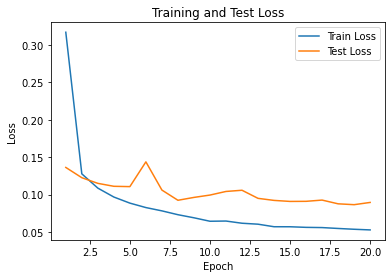

In [71]:
X_train_tensor = torch.Tensor(X_train_balanced)
y_train_tensor = torch.Tensor(y_train_balanced)
X_test_tensor = torch.Tensor(X_test_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define our neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

input_size = X_train_tensor.shape[1]
model = NeuralNet(input_size)

# We defined the loss function and optimizer with L2 regularization
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

batch_size = 32
num_epochs = 20
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

# Start training
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_inputs, batch_labels in train_data_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels.view(-1, 1))
        
        # L2 regularization
        l2_lambda = 0.001
        l2_regularization = torch.tensor(0.)
        for param in model.parameters():
            l2_regularization += torch.norm(param, 2)
        loss += l2_lambda * l2_regularization
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_inputs.size(0)
    
    # Update the learning rate as we made its value dynamic
    scheduler.step(running_loss)
    
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Evaluate the model on the test data
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test.view(-1, 1))
        test_losses.append(test_loss.item())
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Test Loss: {test_loss.item()}")


# Vizualization
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Get predictions on unseed data
with torch.no_grad():
    model.eval()
    predicted_probs = model(X_test_tensor)

# Convert probabilities to binary predictions
predicted_labels = (predicted_probs >= 0.5).float().squeeze().numpy()

From this graph we can clearly see if the model will be overfitting, test loss would be increasing and train loss decreasing. If we add more epochs we would be still able to observe this so in that case there is possibility to add more regularization or make architecture more simple.

In [74]:
y_test_np = y_test.numpy()

rf_scores_test = evaluate(y_test_np, predicted_labels, 'custom_NN_test')
results_df = pd.concat([results_df,rf_scores_test], ignore_index=False, sort=False)
results_df.head(20)

,F-score,Precision,Accuracy,Recall
logistic_regression_train_v1,0.767749,0.825442,0.893878,0.733736
logistic_regression_test_v1,0.770607,0.832473,0.887441,0.735834
logistic_regression_train_v2,0.777363,0.745064,0.854378,0.852135
logistic_regression_test_v2,0.782388,0.753382,0.851896,0.844242
mlp_train_v1,0.779465,0.746933,0.855958,0.854097
mlp_test_v1,0.782691,0.753878,0.852686,0.842903
mlp_train_v2,0.987022,0.979278,0.993022,0.995178
mlp_test_v2,0.878598,0.869188,0.928910,0.888943
rf_train_v1,1.000000,1.000000,1.000000,1.000000
rf_test_v1,0.915290,0.935881,0.953791,0.897614
